# Bike-Sharing Demand

## CRISP-DM Methodology

### Business Understanding

- Could include the idea of the casual vs registered users. "Thought about dropping these features but then thought these numbers could be affected by weather etc. "

### Data Understanding

**datetime** - hourly date + timestamp  <br>
**season** 
-  1 = spring
-  2 = summer 
-  3 = fall
-  4 = winter<br>

**holiday** - whether the day is considered a holiday<br>
**workingday** - whether the day is neither a weekend nor holiday<br>
**weather** 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist            
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius<br>
**atemp** - "feels like" temperature in Celsius<br>
**humidity** - relative humidity<br>
**windspeed** - wind speed<br>
**casual** - number of non-registered user rentals initiated<br>
**registered** - number of registered user rentals initiated<br>
**count** - number of total rentals<br>

In [107]:
# Import pandas, numpy and matplotlib libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from sklearn.utils import shuffle
from sklearn import metrics
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import statsmodels.formula.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold

In [108]:
# Convert csv file into dataframes
df1 = pd.read_csv('FullDataset.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
# Print the first 5 rows
df1.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [109]:
# Print the last 5 rows
df1.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [110]:
# Check how many rows and columns this dataframe has
df1.shape

(10886, 12)

In [111]:
#How many rows?
df1.shape[0]

10886

In [112]:
#How many columns?
df1.shape[1]

12

In [113]:
# checks dataframe and prints out the name of any constant columns
# checks if constant by seeing if any column's number of unique values equals 1
count=0
for column in df1:
    if len(df1[column].unique()) == 1:
        count += 1
        print(column + " is constant")
if count==0:
    print("There are no constant columns")

There are no constant columns


In [114]:
#this would drop duplicated columns if they existed (which they didn't)
df1 = df1.loc[:,~df1.columns.duplicated()]
df1.shape

(10886, 12)

In [115]:
#checked for duplicate rows, of which there are none
print(df1.set_index('datetime').index.get_duplicates())

[]


In [116]:
#Show the data type of each column
df1.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [117]:
# Select columns containing categorical data
categorical_columns = df1[['season','holiday','workingday','weather']]
# Convert data type to category for these columns
for column in categorical_columns:
    df1[column] = df1[column].astype('category')
# Select columns containing continuous data
continuous_columns = df1.select_dtypes(exclude=['category']).columns
#Remove datetime (our index) from the continuous columns as it is neither a continuous or categorical feature
continuous_columns = continuous_columns.drop('datetime')
df1.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

In [118]:
# Check whether there are null values in the data where values would be expected
df1.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [119]:
#Check unique values for each feature
print("Feature, UniqueValues") 
for column in df1:
    print(column + "," + str(len(df1[column].unique())))

Feature, UniqueValues
datetime,10886
season,4
holiday,2
workingday,2
weather,4
temp,49
atemp,60
humidity,89
windspeed,28
casual,309
registered,731
count,822


In [120]:
# Print table
df1.select_dtypes(['category']).describe().T

,count,unique,top,freq
season,10886,4,4,2734
holiday,10886,2,0,10575
workingday,10886,2,1,7412
weather,10886,4,1,7192


In [121]:
# Print table
df1[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


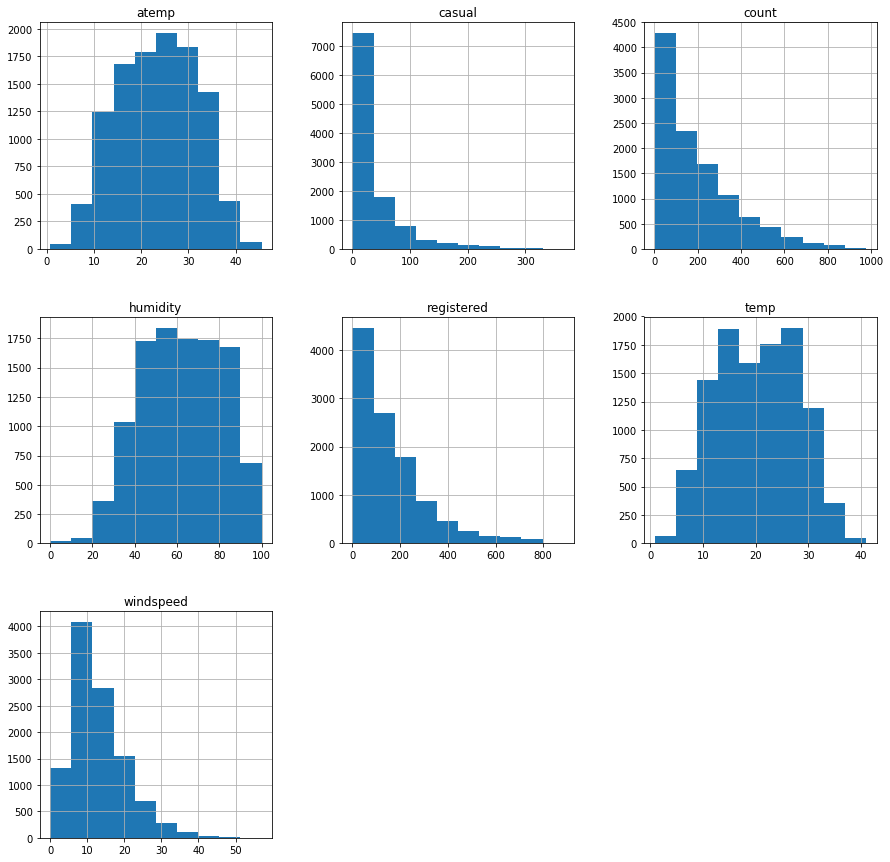

In [122]:
# Plot a histogram of the continuous features and save in a PDF file
df1[continuous_columns].hist(figsize=(15,15))
plt.savefig('continuous_histograms_17203166.pdf')

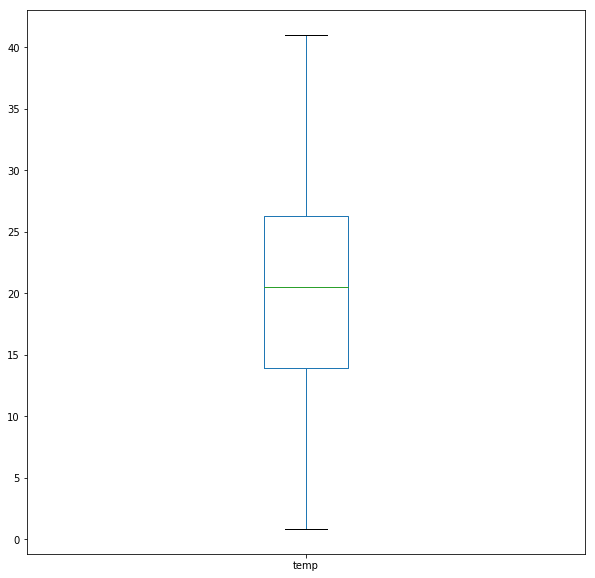

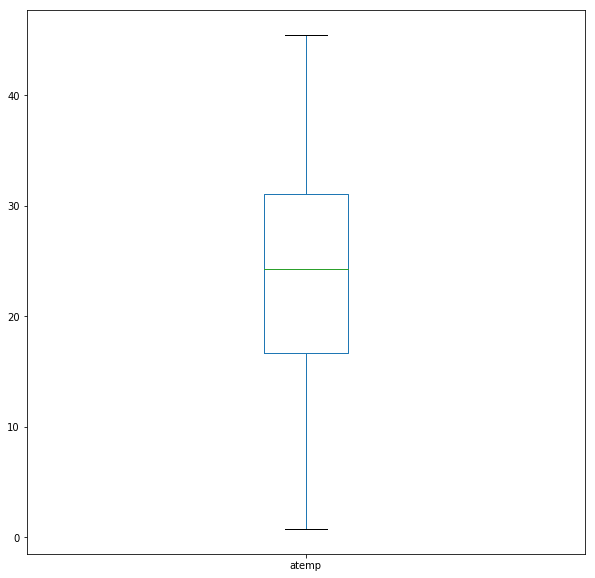

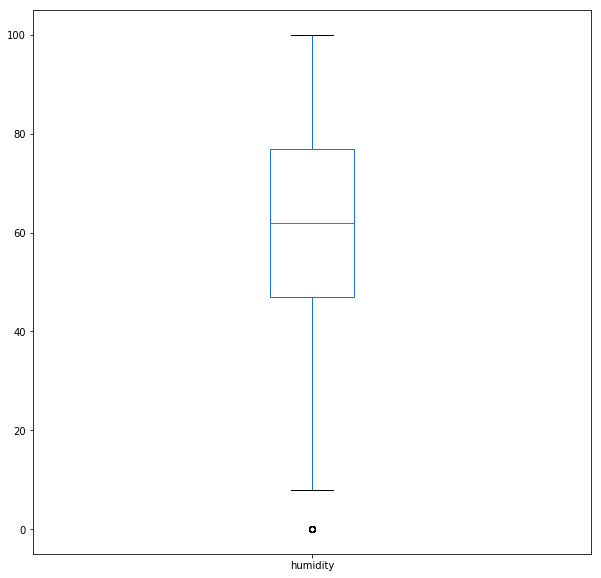

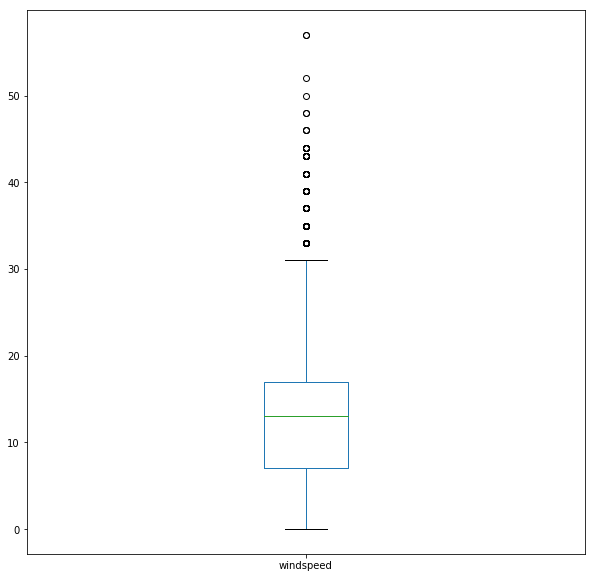

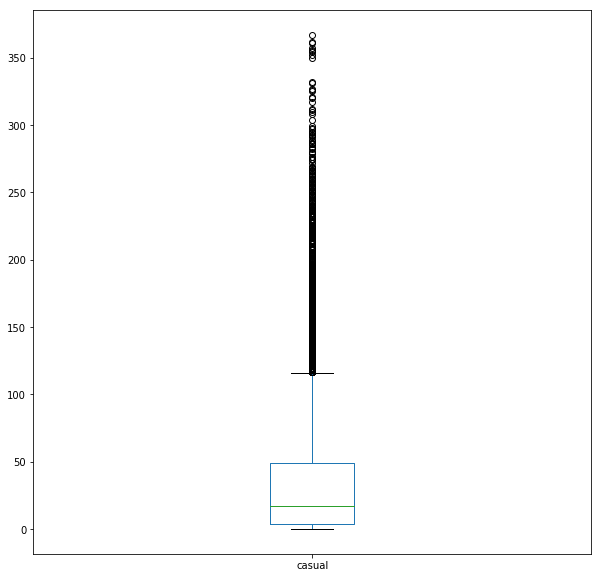

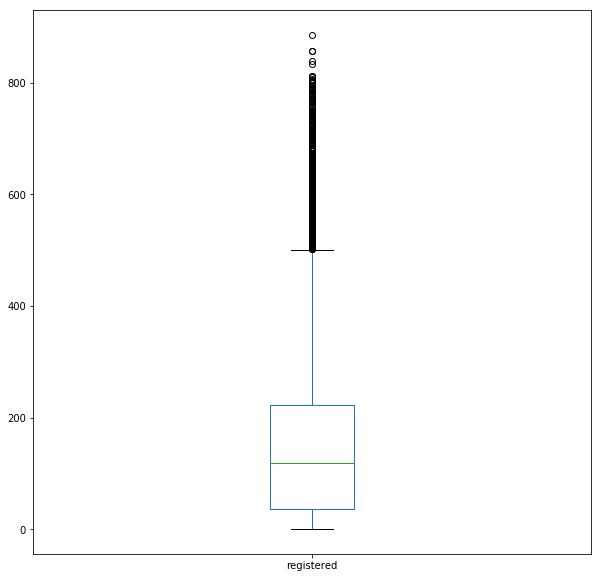

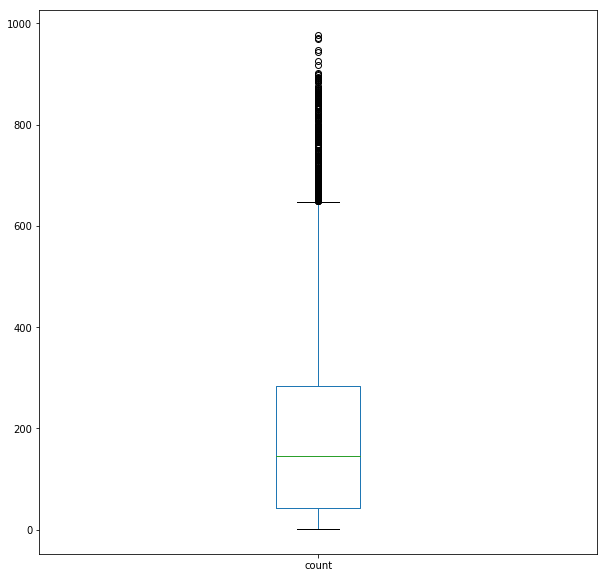

In [123]:
# Plot box plots for all the continuous features and save in a PDF file
pp = PdfPages('continuous_box_plots.pdf')

for col in continuous_columns:
    f = df1[col].plot(kind='box', figsize=(10,10))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

In [124]:
# Look at correlations for all the continuous features.
df1[continuous_columns].corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


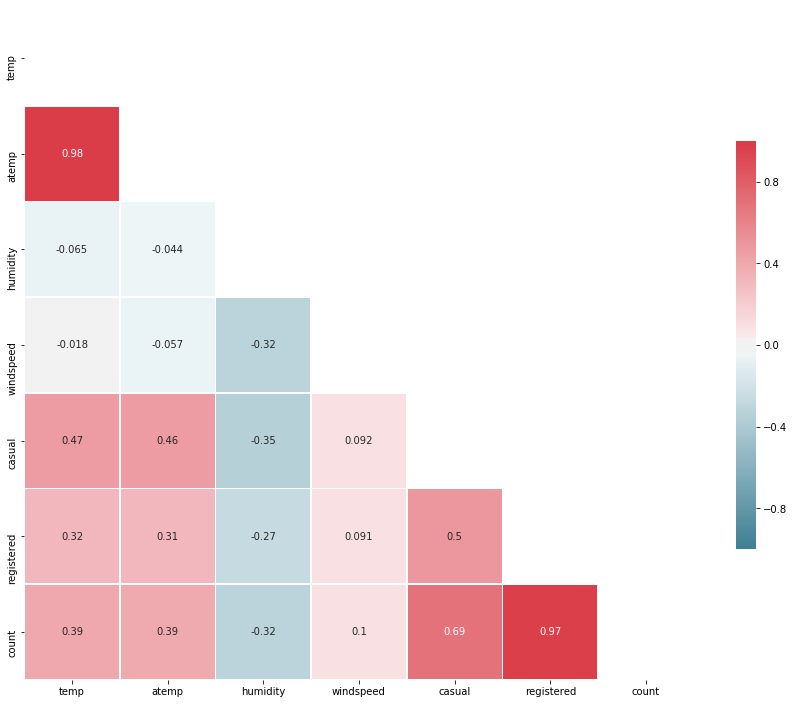

In [125]:
#Heatmap showing the correlation between different continuous feature pairs
corr = df1[continuous_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

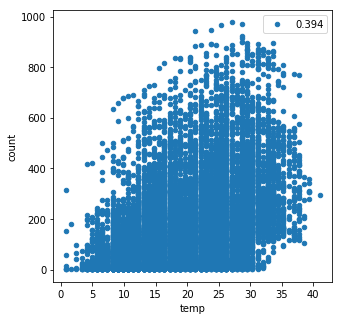

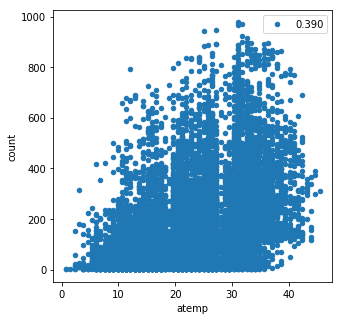

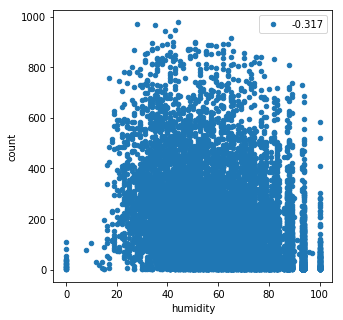

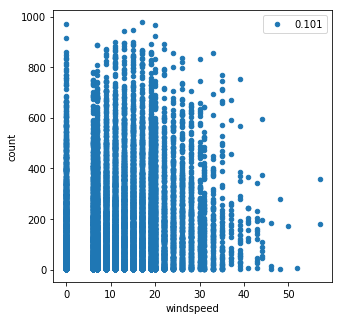

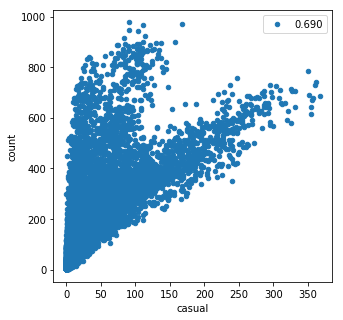

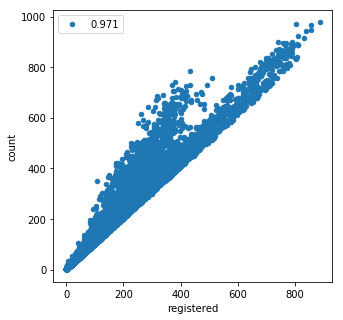

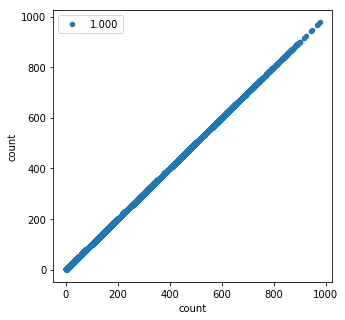

In [126]:
# Scatterplots for correlation between each continuous feature and churn
for col in continuous_columns:
    df1.plot(kind='scatter', x=col, y='count', label="%.3f" % df1[[col, 'count']].corr().as_matrix()[0,1], figsize=(5, 5))

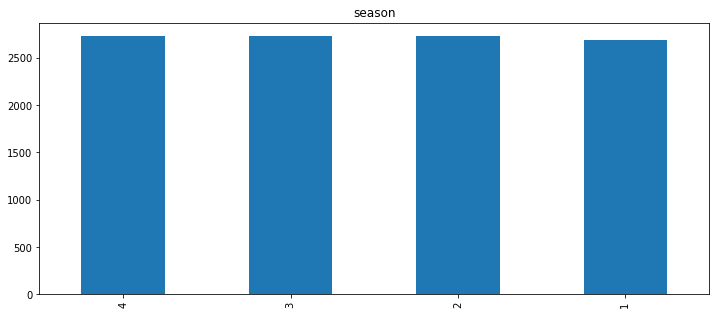

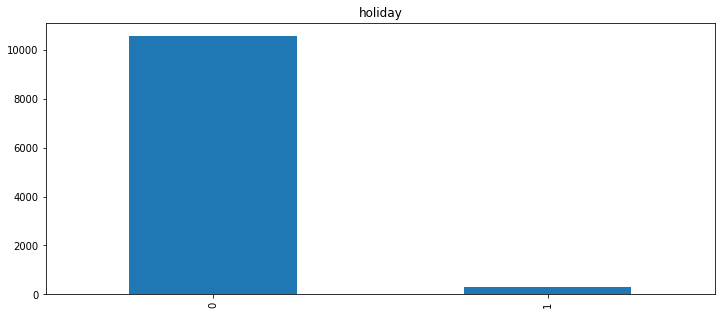

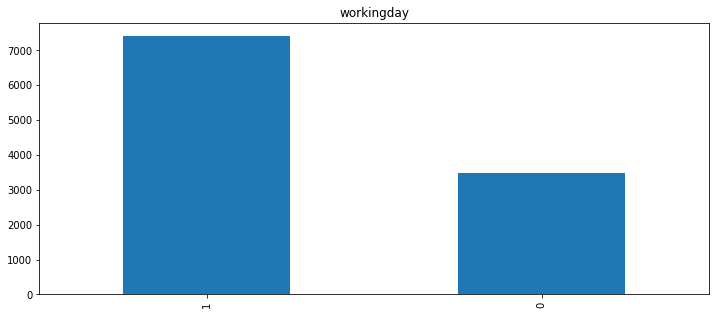

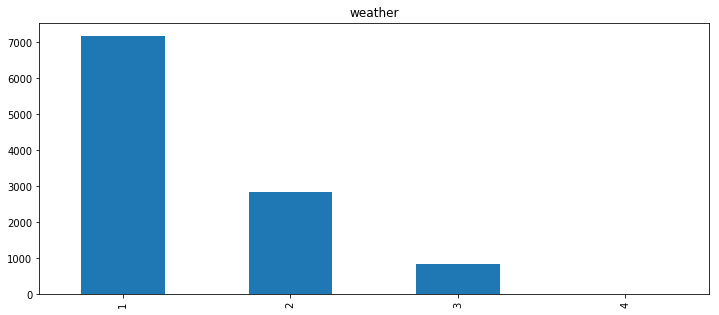

In [127]:
# Plot bar charts for all categorical features and save them in a single PDF file
pp = PdfPages('categorical_bar_charts.pdf')

for column in categorical_columns:
    f = df1[column].value_counts().plot(kind='bar', title=column, figsize=(12,5))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

/Users/clawlor90/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


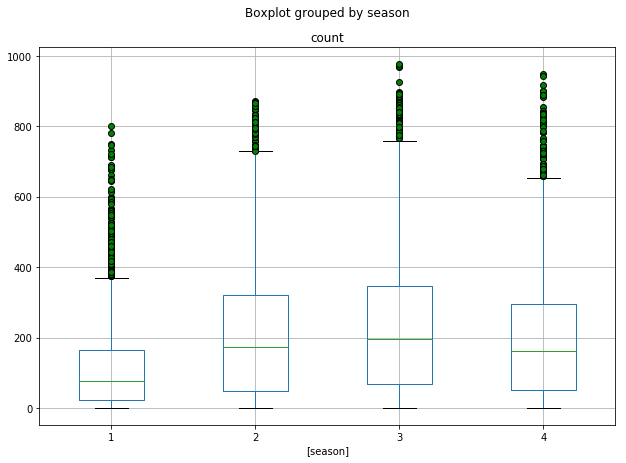

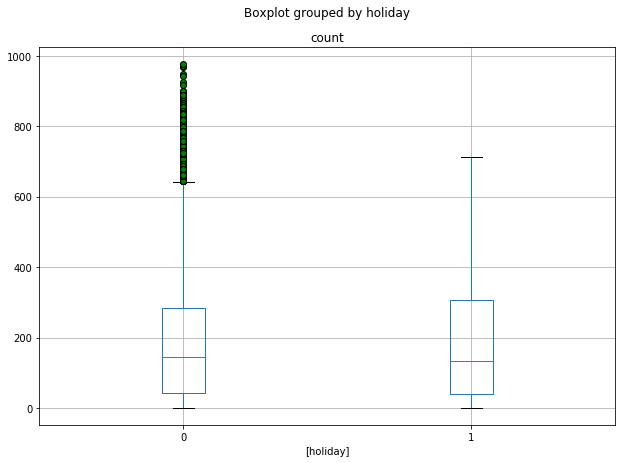

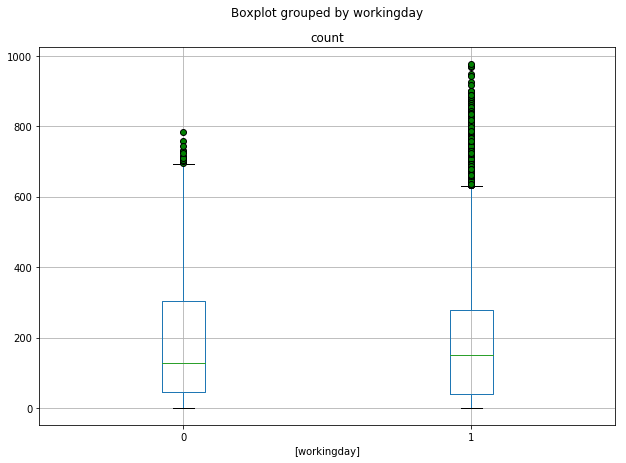

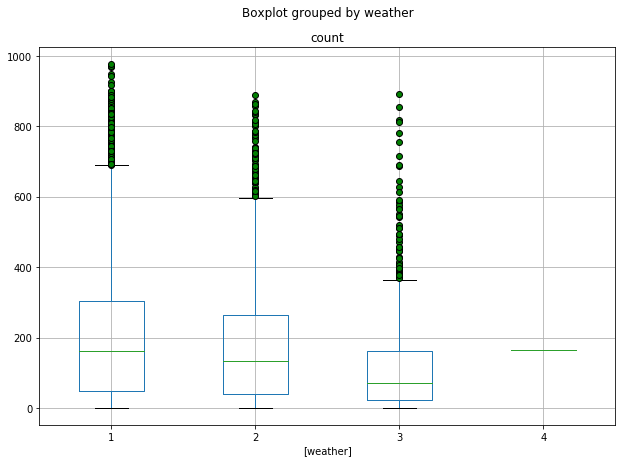

In [128]:
#Boxplots showing interaction between each continuous feature and the target feature
pp = PdfPages('categorical_vs_count_boxplots.pdf') #Save figures to a PDF
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
for col in categorical_columns:
    bp = df1.boxplot(column=['count'], by=[col], flierprops=flierprops, figsize=(10,7))
    pp.savefig(f.get_figure())    
pp.close()

In [129]:
# Return the number of customers for each unique value for feature Age
df1.groupby('weather')['weather'].apply(lambda x: x.count())

weather
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [130]:
# Return the number of customers for each unique value for feature Age
df1.groupby('holiday')['holiday'].apply(lambda x: x.count())

holiday
0    10575
1      311
Name: holiday, dtype: int64

### Data Preparation

In [131]:
#Randomly shuffle the rows in the dataset
#df1 = shuffle(df1)
#df1.to_csv('shuffled.csv', index=False)

In [132]:
#Load in shuffled csv
shuffled = pd.read_csv('shuffled.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [133]:
#Split the dataset into two datasets: 70% training and 30% test.
twosets = np.split(shuffled, [700], axis=0)
dftrain = twosets[0]
dftest = twosets[1]
#Save the training dataframe to a csv
dftrain.to_csv('dftrain.csv',index=False)
#Save the test dataframe to a csv
dftest.to_csv('dftest.csv',index=False)

In [134]:
# Convert the training csv file into dataframe
train = pd.read_csv('dftrain.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [135]:
# Select columns containing categorical data
categorical_columns = dftrain[['season','holiday','workingday','weather']]
# Convert data type to category for these columns
for column in categorical_columns:
    dftrain[column] = dftrain[column].astype('category')
# Select columns containing continuous data
continuous_columns = dftrain.select_dtypes(exclude=['category']).columns
#Remove datetime (our index) from the continuous columns as it is neither a continuous or categorical feature
continuous_columns = continuous_columns.drop('datetime')
dftrain.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

In [152]:
# Build a learning machine using the subset of features chosen in part 1
lm = sm.ols(formula="count ~ weather + season", data=dftrain).fit()

# Print the model parameters (e.g coefficients)
print(lm.params)

Intercept       128.882628
weather[T.2]    -21.287395
weather[T.3]    -61.662066
season[T.2]      77.682485
season[T.3]     111.987463
season[T.4]      75.700439
dtype: float64


In [153]:
#Print the learning machine summary which is a bit more detailed than just the coefficients
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     9.074
Date:                Thu, 12 Apr 2018   Prob (F-statistic):           2.27e-08
Time:                        14:49:54   Log-Likelihood:                -4583.3
No. Observations:                 700   AIC:                             9179.
Df Residuals:                     694   BIC:                             9206.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      128.8826     14.617      8.817   

In [154]:
dftrain_predict = lm.predict(dftrain)
# Print the predicted target feature value for first 100 examples in the training dataset
dftrain_predict[:10]

0    107.595233
1    240.870091
2    204.583067
3    240.870091
4    206.565113
5    185.277718
6    128.882628
7    240.870091
8    240.870091
9    185.277718
dtype: float64

In [155]:
dftrain[['count']][:10]

,count
0,157
1,514
2,174
3,73
4,105
5,233
6,38
7,151
8,389
9,59


In [156]:
# Threshold the predicted dataset at 0.5
threshold = pd.DataFrame(dftrain_predict>199) *1.0
threshold[:10]

,0
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,0.0
6,0.0
7,1.0
8,1.0
9,0.0


### Modeling

### Model Evaluation

### Deployment

In [137]:
# notebook intitialised